In [71]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix, roc_curve, auc
from sklearn.preprocessing import label_binarize

In [72]:
np.random.seed(42)

X shape: (1500, 2)
y shape: (1500,)
Number of classes: 5


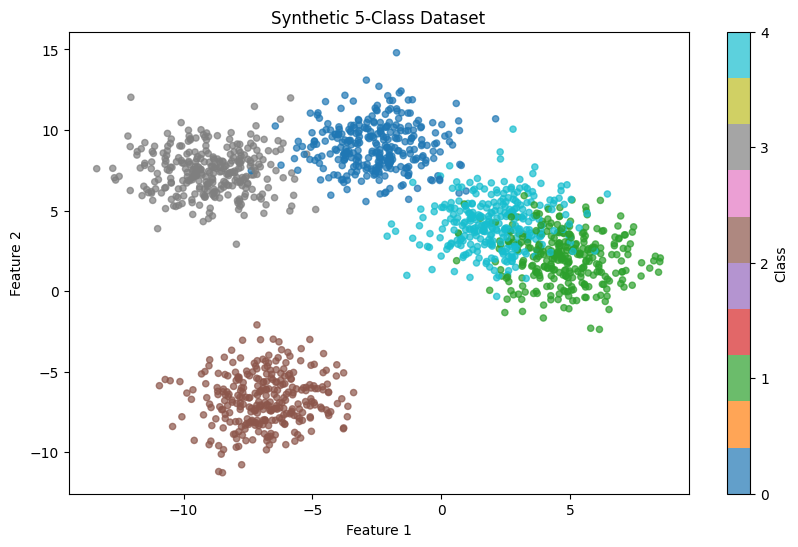

In [73]:
n_samples = 1500
n_features = 2
n_classes = 5

X, y = make_blobs(
    n_samples=n_samples,
    centers=n_classes,
    n_features=n_features,
    cluster_std=1.5,
    random_state=42
)

print("X shape:", X.shape)
print("y shape:", y.shape)
print("Number of classes:", len(np.unique(y)))

plt.figure(figsize=(10, 6))
scatter = plt.scatter(X[:, 0], X[:, 1], c=y, cmap='tab10', s=20, alpha=0.7)
plt.title("Synthetic 5-Class Dataset")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.colorbar(scatter, ticks=range(n_classes), label="Class")
plt.show()

In [74]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

print("Train shape:", X_train.shape, y_train.shape)
print("Test shape:", X_test.shape, y_test.shape)

def one_hot_encode(y, num_classes):
    oh = np.zeros((y.shape[0], num_classes))
    oh[np.arange(y.shape[0]), y] = 1
    return oh

y_train_oh = one_hot_encode(y_train, n_classes)
y_test_oh  = one_hot_encode(y_test, n_classes)

Train shape: (1050, 2) (1050,)
Test shape: (450, 2) (450,)


In [75]:
def relu(z):
    return np.maximum(0, z)

def relu_derivative(z):
    return (z > 0).astype(float)

def softmax(z):
    z_shifted = z - np.max(z, axis=1, keepdims=True)
    exp_z = np.exp(z_shifted)
    return exp_z / np.sum(exp_z, axis=1, keepdims=True)

def cross_entropy_loss(y_true, y_pred, eps=1e-12):
    y_pred_clipped = np.clip(y_pred, eps, 1.0 - eps)
    loss = -np.sum(y_true * np.log(y_pred_clipped)) / y_true.shape[0]
    return loss

In [76]:
class NeuralNetwork:
    def __init__(self, input_dim, hidden_dims, output_dim, lr=0.01):
        assert len(hidden_dims) == 3
        self.lr = lr

        h1, h2, h3 = hidden_dims
        self.W1 = np.random.randn(input_dim, h1) * np.sqrt(2.0 / input_dim)
        self.b1 = np.zeros((1, h1))

        self.W2 = np.random.randn(h1, h2) * np.sqrt(2.0 / h1)
        self.b2 = np.zeros((1, h2))

        self.W3 = np.random.randn(h2, h3) * np.sqrt(2.0 / h2)
        self.b3 = np.zeros((1, h3))

        self.W4 = np.random.randn(h3, output_dim) * np.sqrt(2.0 / h3)
        self.b4 = np.zeros((1, output_dim))

    def forward(self, X):
        self.Z1 = X @ self.W1 + self.b1
        self.A1 = relu(self.Z1)

        self.Z2 = self.A1 @ self.W2 + self.b2
        self.A2 = relu(self.Z2)

        self.Z3 = self.A2 @ self.W3 + self.b3
        self.A3 = relu(self.Z3)

        self.Z4 = self.A3 @ self.W4 + self.b4
        self.A4 = softmax(self.Z4)

        return self.A4

    def backward(self, X, y_true):

        N = X.shape[0]

        dZ4 = (self.A4 - y_true) / N

        dW4 = self.A3.T @ dZ4
        db4 = np.sum(dZ4, axis=0, keepdims=True)

        dA3 = dZ4 @ self.W4.T
        dZ3 = dA3 * relu_derivative(self.Z3)
        dW3 = self.A2.T @ dZ3
        db3 = np.sum(dZ3, axis=0, keepdims=True)

        dA2 = dZ3 @ self.W3.T
        dZ2 = dA2 * relu_derivative(self.Z2)
        dW2 = self.A1.T @ dZ2
        db2 = np.sum(dZ2, axis=0, keepdims=True)

        dA1 = dZ2 @ self.W2.T
        dZ1 = dA1 * relu_derivative(self.Z1)
        dW1 = X.T @ dZ1
        db1 = np.sum(dZ1, axis=0, keepdims=True)

        self.W4 -= self.lr * dW4
        self.b4 -= self.lr * db4

        self.W3 -= self.lr * dW3
        self.b3 -= self.lr * db3

        self.W2 -= self.lr * dW2
        self.b2 -= self.lr * db2

        self.W1 -= self.lr * dW1
        self.b1 -= self.lr * db1

    def train(self, X, y, epochs=200, print_every=20):

        self.loss_history = []
        for epoch in range(1, epochs + 1):

            probs = self.forward(X)
            loss = cross_entropy_loss(y, probs)
            self.loss_history.append(loss)


            self.backward(X, y)

            if epoch % print_every == 0 or epoch == 1:
                print(f"Epoch {epoch:4d} ,  Loss: {loss:.4f}")

    def predict_proba(self, X):
        probs = self.forward(X)
        return probs

    def predict(self, X):
        probs = self.predict_proba(X)
        return np.argmax(probs, axis=1)

Epoch    1 ,  Loss: 8.9193
Epoch   25 ,  Loss: 0.2315
Epoch   50 ,  Loss: 0.2024
Epoch   75 ,  Loss: 0.1920
Epoch  100 ,  Loss: 0.1909
Epoch  125 ,  Loss: 0.1883
Epoch  150 ,  Loss: 0.1964
Epoch  175 ,  Loss: 0.1866
Epoch  200 ,  Loss: 0.1840
Epoch  225 ,  Loss: 0.1828
Epoch  250 ,  Loss: 0.1855
Epoch  275 ,  Loss: 0.1807
Epoch  300 ,  Loss: 0.1789


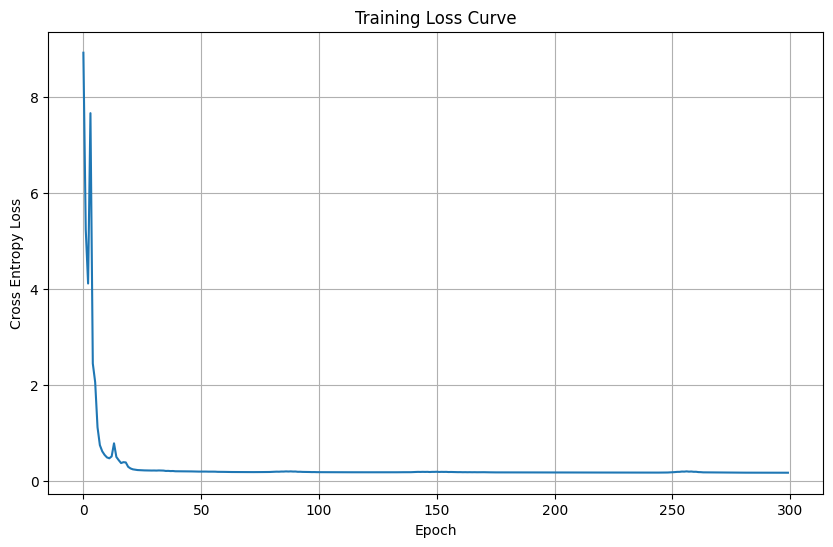

In [82]:
input_dim = X_train.shape[1]
hidden_dims = [64, 32,16]
output_dim = n_classes
learning_rate = 0.05
epochs = 300

model = NeuralNetwork(
    input_dim=input_dim,
    hidden_dims=hidden_dims,
    output_dim=output_dim,
    lr=learning_rate
)

model.train(X_train, y_train_oh, epochs=epochs, print_every=25)

plt.figure(figsize=(10,6))
plt.plot(model.loss_history)
plt.xlabel("Epoch")
plt.ylabel("Cross Entropy Loss")
plt.title("Training Loss Curve")
plt.grid(True)
plt.show()


In [91]:
y_test_pred = model.predict(X_test)
y_test_proba = model.predict_proba(X_test)

test_accuracy = accuracy_score(y_test, y_test_pred)
print(f"Test Accuracy: {test_accuracy:.4f}")

prec, rec, f1, support = precision_recall_fscore_support(
    y_test, y_test_pred, labels=range(n_classes), zero_division=0
)

for i in range(n_classes):
    print(
        f"Class {i}: "
        f"Precision={prec[i]:.4f}  "
        f"Recall={rec[i]:.4f}  "
        f"F1={f1[i]:.4f}  "
        f"Support={support[i]}"
    )
print("\nMacro-averaged")
print("Precision: {:.4f}".format(np.mean(prec)))
print("Recall:    {:.4f}".format(np.mean(rec)))
print("F1-score:  {:.4f}".format(np.mean(f1)))

print("\nDetailed classification report:\n")
print(classification_report(y_test, y_test_pred, digits=4))

Test Accuracy: 0.9044
Class 0: Precision=0.9053  Recall=0.9556  F1=0.9297  Support=90
Class 1: Precision=0.9067  Recall=0.7556  F1=0.8242  Support=90
Class 2: Precision=1.0000  Recall=1.0000  F1=1.0000  Support=90
Class 3: Precision=0.9670  Recall=0.9778  F1=0.9724  Support=90
Class 4: Precision=0.7576  Recall=0.8333  F1=0.7937  Support=90

Macro-averaged
Precision: 0.9073
Recall:    0.9044
F1-score:  0.9040

Detailed classification report:

              precision    recall  f1-score   support

           0     0.9053    0.9556    0.9297        90
           1     0.9067    0.7556    0.8242        90
           2     1.0000    1.0000    1.0000        90
           3     0.9670    0.9778    0.9724        90
           4     0.7576    0.8333    0.7937        90

    accuracy                         0.9044       450
   macro avg     0.9073    0.9044    0.9040       450
weighted avg     0.9073    0.9044    0.9040       450



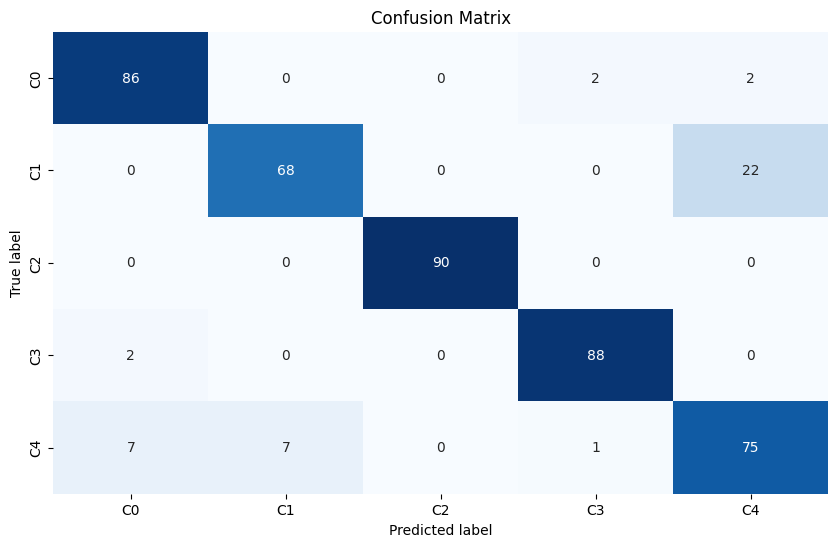

In [92]:
cm = confusion_matrix(y_test, y_test_pred)

plt.figure(figsize=(10,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=[f"C{i}" for i in range(n_classes)],
            yticklabels=[f"C{i}" for i in range(n_classes)])
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.title("Confusion Matrix")
plt.show()

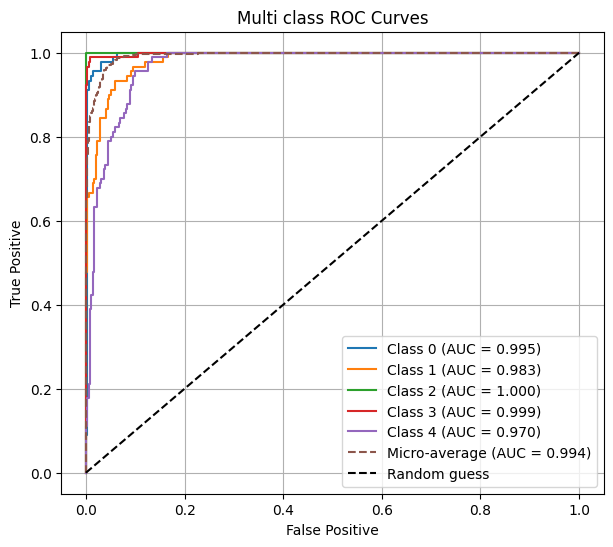

In [93]:
y_test_bin = label_binarize(y_test, classes=range(n_classes))

fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_test_proba[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

fpr["micro"], tpr["micro"], _ = roc_curve(
    y_test_bin.ravel(), y_test_proba.ravel()
)
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

plt.figure(figsize=(7,6))

for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label=f"Class {i} (AUC = {roc_auc[i]:.3f})")

plt.plot(fpr["micro"], tpr["micro"],
         label=f"Micro-average (AUC = {roc_auc['micro']:.3f})",
         linestyle='--')
plt.plot([0,1],[0,1],'k--', label="Random guess")
plt.xlabel("False Positive")
plt.ylabel("True Positive")
plt.title("Multi class ROC Curves")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

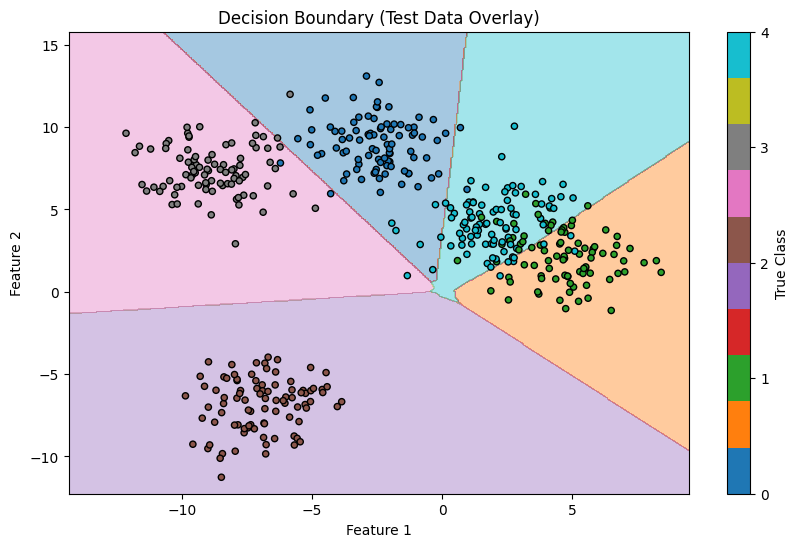

In [94]:
h = 0.05

x_min, x_max = X[:, 0].min() - 1.0, X[:, 0].max() + 1.0
y_min, y_max = X[:, 1].min() - 1.0, X[:, 1].max() + 1.0

xx, yy = np.meshgrid(
    np.arange(x_min, x_max, h),
    np.arange(y_min, y_max, h)
)

grid_points = np.c_[xx.ravel(), yy.ravel()]
Z = model.predict(grid_points)
Z = Z.reshape(xx.shape)

plt.figure(figsize=(10,6))
plt.contourf(xx, yy, Z, alpha=0.4, cmap='tab10')
scatter = plt.scatter(X_test[:, 0], X_test[:, 1], c=y_test, cmap='tab10', s=20, edgecolor='k')
plt.title("Decision Boundary (Test Data Overlay)")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.colorbar(scatter, ticks=range(n_classes), label="True Class")
plt.show()